## This notebook:
* Find the number of topics for LDA based on topic coherence


In [1]:
import pandas as pd
import neattext.functions as nfx

In [2]:
import numpy as np
import json
import glob

from collections import Counter, defaultdict

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
import nltk
# nltk.download()
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore")

pyLDAvis.enable_notebook()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [3]:
online = pd.read_csv('assets/original/2021-10-19-MichiganOnline-courses.csv')
f_21 = pd.read_csv('assets/f_21_merge.csv')
w_22 = pd.read_csv('assets/w_22_merge.csv')

In [4]:
def prepare_text(df):

    data = df['description'].dropna()


    def lemmatization(texts, allowed_postags=["NOUN"]): #trying only noun instead ["NOUN", "ADJ", "VERB", "ADV"]
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        texts_out = []
        for text in texts:
            doc = nlp(text)
            new_text = []
            for token in doc:
                if token.pos_ in allowed_postags:
                    new_text.append(token.lemma_)
            #final = " ".join(new_text)
            texts_out.append(new_text)
        return (texts_out)

    lemmatized_texts = lemmatization(data)

    def stop_word_removal(texts):

        flat_texts = [t for text in texts for t in text]
        common_words = [k for k,v in Counter(flat_texts).most_common(10)]
        texts_out = []
        stop = set(stopwords.words('english')+common_words)
        for text in texts:
            new_text = [t for t in text if t.lower() not in stop]
            final = " ".join(new_text)
            texts_out.append(final)
        return (texts_out)

    stop_word_removed_texts = stop_word_removal(lemmatized_texts)


    def gen_words(texts):
        final = []
        for text in texts:
            new = gensim.utils.simple_preprocess(text, deacc=True)
            final.append(new)
        return (final)

    data_words = gen_words(stop_word_removed_texts)


    # Create bigrams and trigrams
    bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)

    def make_bigrams(texts):
        return([bigram[doc] for doc in texts])

    def make_trigrams(texts):
        return ([trigram[bigram[doc]] for doc in texts])

    data_bigrams = make_bigrams(data_words)
    data_bigrams_trigrams = make_trigrams(data_bigrams)


    return data_bigrams_trigrams

texts = prepare_text(f_21)

In [9]:
from gensim.models.ldamulticore import LdaMulticore

corpus = texts

def calc_coherence_values(texts, limit = 12, start = 1, step = 1):
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,id2word = id2word, num_topics = num_topics, alpha=.1, eta=0.1, random_state = 42)
        model_list.append(model)
        print('model created')
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = id2word, coherence = 'c_v')
        print(coherencemodel.get_coherence())
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = calc_coherence_values(texts = texts, start = 20, 
                                                     limit = 30, 
                                                     step = 1)

model created
0.46840548423370576
model created
0.46073397368511815
model created
0.431368164030561
model created
0.5131176004905323
model created
0.45299637455933733
model created
0.4713712621836049
model created
0.44045701213059135
model created
0.44020109622570014
model created
0.46768284772359703
model created
0.4940457083473577


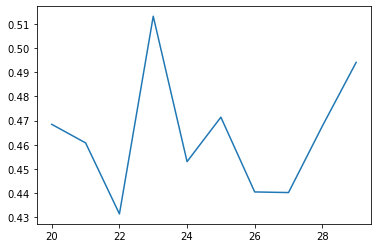

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.arange(20,30), coherence_values)